# Context

This notebook is designed to extract two critical sections from 10-K filings. Following a manual review of 50 10-Ks, it has been observed that the majority of mentions regarding climate change occur in sections 1 (Business) and 1A (Risk Factors), with only one exception noted. Therefore, the NLP analysis will primarily concentrate on keyword counts within these sections. The text data extraction is performed using the SEC's API, which has limitations on free API calls.

### All 10-K sections can be extracted:

- 1 - Business
- 1A - Risk Factors
- 1B - Unresolved Staff Comments
- 2 - Properties
- 3 - Legal Proceedings
- 4 - Mine Safety Disclosures
- 5-  - Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities
- 6 - Selected Financial Data (prior to February 2021)
- 7 - Management’s Discussion and Analysis of Financial Condition and Results of Operations
- 7A - Quantitative and Qualitative Disclosures about Market Risk
- 8 - Financial Statements and Supplementary Data
- 9 - Changes in and Disagreements with Accountants on Accounting and Financial Disclosure
- 9A - Controls and Procedures
- 9B - Other Information
- 10 - Directors, Executive Officers and Corporate Governance
- 11 - Executive Compensation
- 12 - Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters
- 13 - Certain Relationships and Related Transactions, and Director Independence
- 14 - Principal Accountant Fees and Services





In [ ]:
pip install sec-api

In [65]:
pip install nltk

In [66]:
from sec_api import ExtractorApi
import pandas as pd
import numpy as np
import re
import html
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Get dataset with SEC URLs

In [8]:
df=pd.read_csv('20240322_S&P50_latest_SEC_10k_links.csv')
df.head()

,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,SEC_10K
0,1,Microsoft,MSFT,https://www.microsoft.com,"$3,002,343,620,608",3002 B,2023.0,7/27/2023,6/30/2023,https://www.sec.gov/Archives/edgar/data/789019...
1,2,Apple Inc.,AAPL,https://www.apple.com,"$2,815,212,650,496",2815 B,2023.0,11/3/2023,9/30/2023,https://www.sec.gov/Archives/edgar/data/320193...
2,3,Nvidia,NVDA,https://www.nvidia.com,"$1,793,541,144,576",1794 B,2023.0,2/24/2023,1/29/2023,https://www.sec.gov/Archives/edgar/data/104581...
3,4,Amazon,AMZN,https://www.aboutamazon.com,"$1,760,768,032,768",1761 B,2023.0,2/2/2024,12/31/2023,https://www.sec.gov/Archives/edgar/data/101872...
4,5,Alphabet Inc. (Class A),GOOGL,https://abc.xyz,"$1,754,293,862,400",1754 B,2023.0,1/31/2024,12/31/2023,https://www.sec.gov/Archives/edgar/data/165204...


In [9]:
df.columns

Index(['Rank', 'company_name', 'stock_symbol', 'website', 'market_cap',
       'market_cap_pretty', 'Filed for Year', 'Filed', 'Filed For Date',
       'SEC_10K'],
      dtype='object')

# Test API connection with one example

In [3]:
from sec_api import ExtractorApi

extractorApi = ExtractorApi("YOUR_API_KEY")


# 10-K example

# MSFT 10-K filing
filing_url_10k = "https://www.sec.gov/Archives/edgar/data/789019/000095017023035122/msft-20230630.htm"


# get the standardized and cleaned text of section 1A "Risk Factors"
section_business_text = extractorApi.get_section(filing_url_10k, "1", "text")

# get the standardized and cleaned text of section 1A "Risk Factors"
section_risk_text = extractorApi.get_section(filing_url_10k, "1A", "text")



In [4]:
section_business_text

" ITEM 1. B USINESS \n\nGENERAL \n\nEmbracing Our Future \n\nMicrosoft is a technology company whose mission is to empower every person and every organization on the planet to achieve more. We strive to create local opportunity, growth, and impact in every country around the world. We are creating the platforms and tools , powered by artificial intelligence (&#8220; AI &#8221;), that deliver better, faster, and more effective solutions to support small and large business competitiveness, improve educational and health outcomes, grow public-sector efficiency, and empower human ingenuity. From infrastructure and data, to business applications and collaboration, we provide unique, differentiated value to customers. \n\nIn a world of increasing economic complexity, AI has the power to revolutionize many types of work. Microsoft is now innovating and expanding our portfolio with AI capabilities to help people and organizations overcome today&#8217;s challenges and emerge stronger. Customers

In [5]:
section_risk_text

" ITEM 1A. RIS K FACTORS \n\nOur operations and financial results are subject to various risks and uncertainties, including those described below, that could adversely affect our business, financial condition, results of operations, cash flows, and the trading price of our common stock. \n\nSTRATEGIC AND COMPETITIVE RISKS \n\nWe face intense competition across all markets for our products and services, which may lead to lower revenue or operating margins. \n\nCompetition in the technology sector \n\nOur competitors range in size from diversified global companies with significant research and development resources to small, specialized firms whose narrower product lines may let them be more effective in deploying technical, marketing, and financial resources. Barriers to entry in many of our businesses are low and many of the areas in which we compete evolve rapidly with changing and disruptive technologies, shifting user needs, and frequent introductions of new products and services. O

# Run function to gather text data for the first 50 companies

In [19]:
def extract_sections(filing_url_10k):
    if isinstance(filing_url_10k, str):  # Check if the value is a string
        extractorApi = ExtractorApi("YOUR_API_KEY")

        # get the standardized and cleaned text of section 1 "Business"
        section_business_text = extractorApi.get_section(filing_url_10k, "1", "text")

        # get the standardized and cleaned text of section 1A "Risk Factors"
        section_risk_text = extractorApi.get_section(filing_url_10k, "1A", "text")

        return section_business_text, section_risk_text
    else:
        return None, None  # Return None if filing_url_10k is not a string


In [20]:
%%time


df['business_text'], df['risk_text'] = zip(*df['SEC_10K'].apply(extract_sections))


CPU times: user 7.45 s, sys: 85.1 ms, total: 7.54 s
Wall time: 31.1 s


In [21]:
df.head()

,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,SEC_10K,business_text,risk_text
0,1,Microsoft,MSFT,https://www.microsoft.com,"$3,002,343,620,608",3002 B,2023.0,7/27/2023,6/30/2023,https://www.sec.gov/Archives/edgar/data/789019...,ITEM 1. B USINESS \n\nGENERAL \n\nEmbracing O...,ITEM 1A. RIS K FACTORS \n\nOur operations and...
1,2,Apple Inc.,AAPL,https://www.apple.com,"$2,815,212,650,496",2815 B,2023.0,11/3/2023,9/30/2023,https://www.sec.gov/Archives/edgar/data/320193...,Item 1. Business \n\nCompany Background \n\nT...,Item 1A. Risk Factors \n\nThe Company&#8217;s...
2,3,Nvidia,NVDA,https://www.nvidia.com,"$1,793,541,144,576",1794 B,2023.0,2/24/2023,1/29/2023,https://www.sec.gov/Archives/edgar/data/104581...,ITEM 1. BUSINESS \n\nOur Company \n\nNVIDIA p...,ITEM 1A. RISK FACTORS \n\nIn evaluating NVIDI...
3,4,Amazon,AMZN,https://www.aboutamazon.com,"$1,760,768,032,768",1761 B,2023.0,2/2/2024,12/31/2023,https://www.sec.gov/Archives/edgar/data/101872...,Item 1. Business ##TABLE_END\n\nThis Annual R...,Item 1A. Risk Factors ##TABLE_END\n\nPlease c...
4,5,Alphabet Inc. (Class A),GOOGL,https://abc.xyz,"$1,754,293,862,400",1754 B,2023.0,1/31/2024,12/31/2023,https://www.sec.gov/Archives/edgar/data/165204...,ITEM 1. BUSINESS \n\nOverview \n\nAs our foun...,ITEM 1A. RISK FACTORS \n\nOur operations and ...


# Basic text cleaning

In [36]:
def clean_text(text):
    if isinstance(text, str):  # Check if text is a string
        # Decode HTML entities
        text = html.unescape(text)

        # Remove newline characters
        text = text.replace('\n', ' ')

        # Remove extra spaces
        text = re.sub(' +', ' ', text)

        # Additional cleaning steps if needed

        return text
    else:
        return np.nan  # Return NaN if text is not a string


In [38]:
df['business_text_clean'] = df['business_text'].apply(clean_text)
df['risk_text_clean'] = df['risk_text'].apply(clean_text)
# df.head()

# Quick view into how frequently do keyword appears

In [40]:
# Define the keywords and their variations
keywords = {
    "climate change": ["climate change", "climate changes"],
    "greenhouse": ["greenhouse", "greenhouses"],
    "sustainability": ["sustainability"]
}

# Function to count keyword occurrences in text
def count_keyword_occurrences(text, keyword_variations):
    if isinstance(text, str):  # Check if text is a string
        count = 0
        for keyword_variation in keyword_variations:
            count += len(re.findall(keyword_variation, text, re.IGNORECASE))
        return count
    else:
        return 0  # Return 0 if text is not a string

# Iterate over each keyword and its variations
for keyword, variations in keywords.items():
    # Create a new column to store the count for each keyword
    df[f'business_text_{keyword.replace(" ", "")}_count'] = df['business_text_clean'].apply(lambda x: count_keyword_occurrences(x, variations))
    df[f'risk_text_{keyword.replace(" ", "")}_count'] = df['risk_text_clean'].apply(lambda x: count_keyword_occurrences(x, variations))



In [43]:
df.columns

Index(['Rank', 'company_name', 'stock_symbol', 'website', 'market_cap',
       'market_cap_pretty', 'Filed for Year', 'Filed', 'Filed For Date',
       'SEC_10K', 'business_text', 'risk_text', 'business_text_clean',
       'risk_text_clean', 'business_text_climatechange_count',
       'risk_text_climatechange_count', 'business_text_greenhouse_count',
       'risk_text_greenhouse_count', 'business_text_sustainability_count',
       'risk_text_sustainability_count'],
      dtype='object')

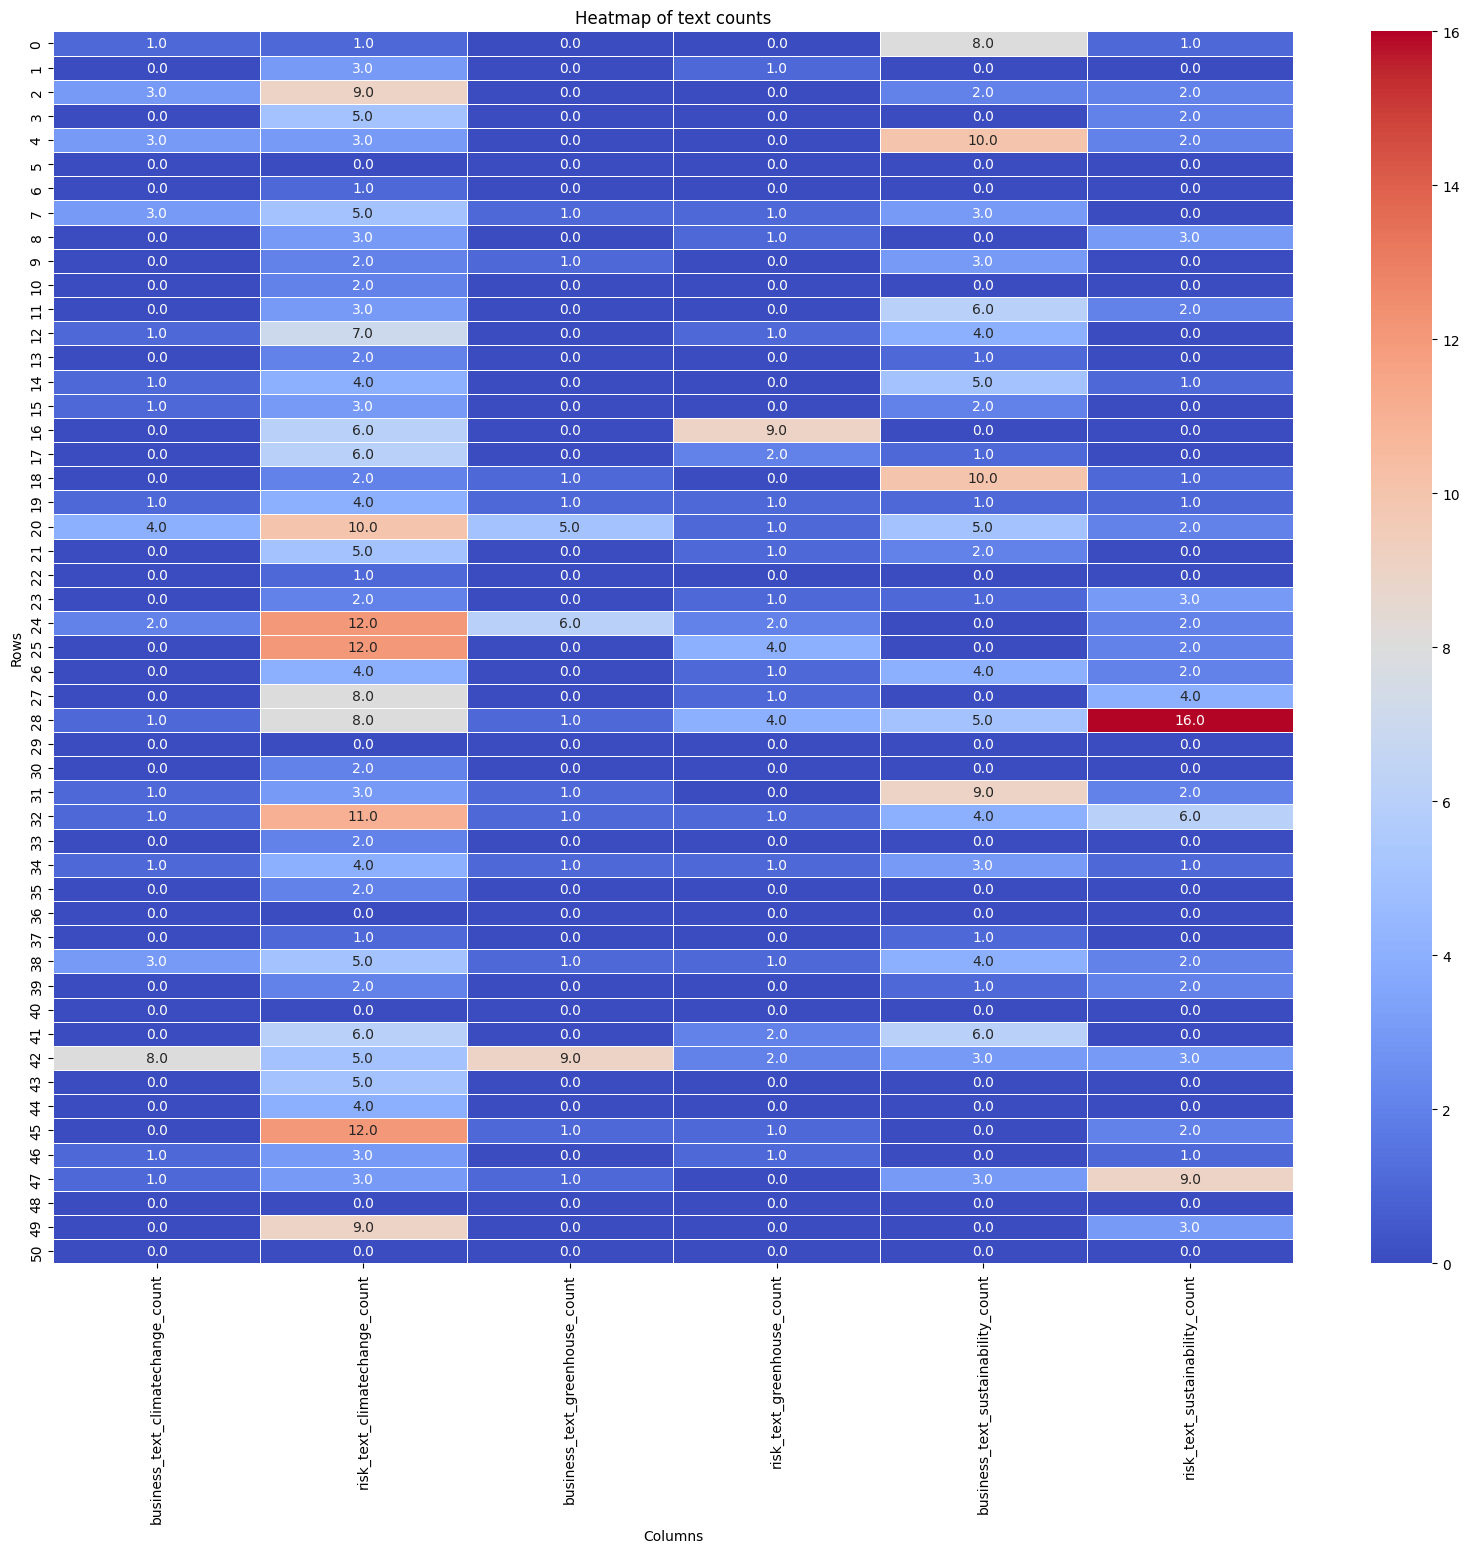

In [46]:
heatmap_data = df.iloc[:, -6:]

plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('Heatmap of text counts')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

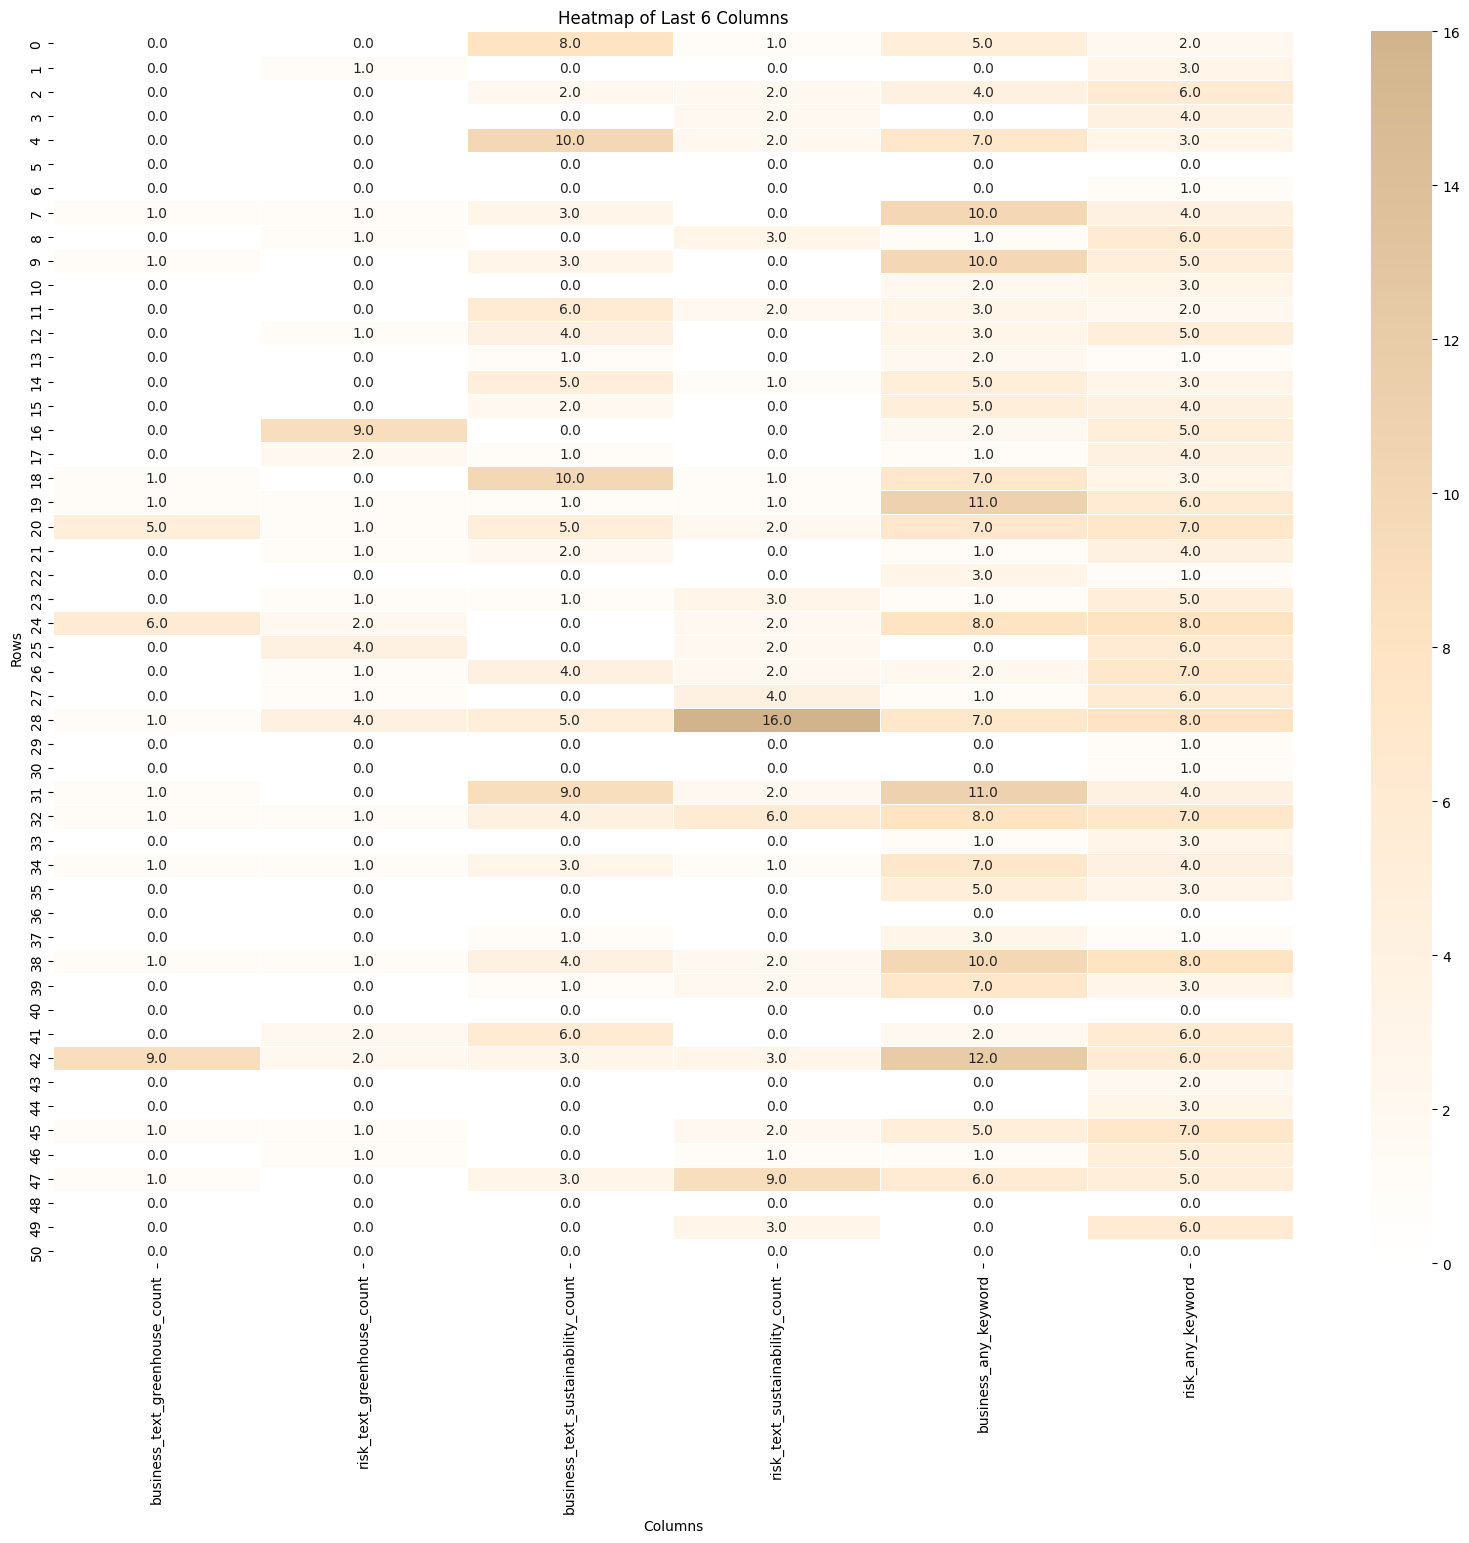

In [78]:
# Custom color map with grey for zero values
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['white', 'bisque', 'tan'])

# Select the last 6 columns
heatmap_data = df.iloc[:, -6:]

# Create the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".1f", linewidths=.5)
plt.title('Heatmap of Last 6 Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [56]:
def count_keywords(text, keywords):
    if isinstance(text, str):  # Check if text is a string
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()

        # Initialize a set to store unique occurrences of keywords
        unique_keywords = set()

        # Iterate through each keyword
        for keyword in keywords:
            # Find all occurrences of the keyword in the text
            occurrences = text_lower.count(keyword.lower())

            # If the keyword appears at least once, add it to the set
            if occurrences > 0:
                unique_keywords.add(keyword)

        # Return the count of unique keywords
        return len(unique_keywords)
    else:
        return 0  # Return 0 for NaN values

# Apply the count_keywords function to each row of the 'business_text_clean' column
df['business_any_keyword'] = df['business_text_clean'].apply(lambda x: count_keywords(x, keywords_list))

# Apply the count_keywords function to each row of the 'risk_text_clean' column
df['risk_any_keyword'] = df['risk_text_clean'].apply(lambda x: count_keywords(x, keywords_list))


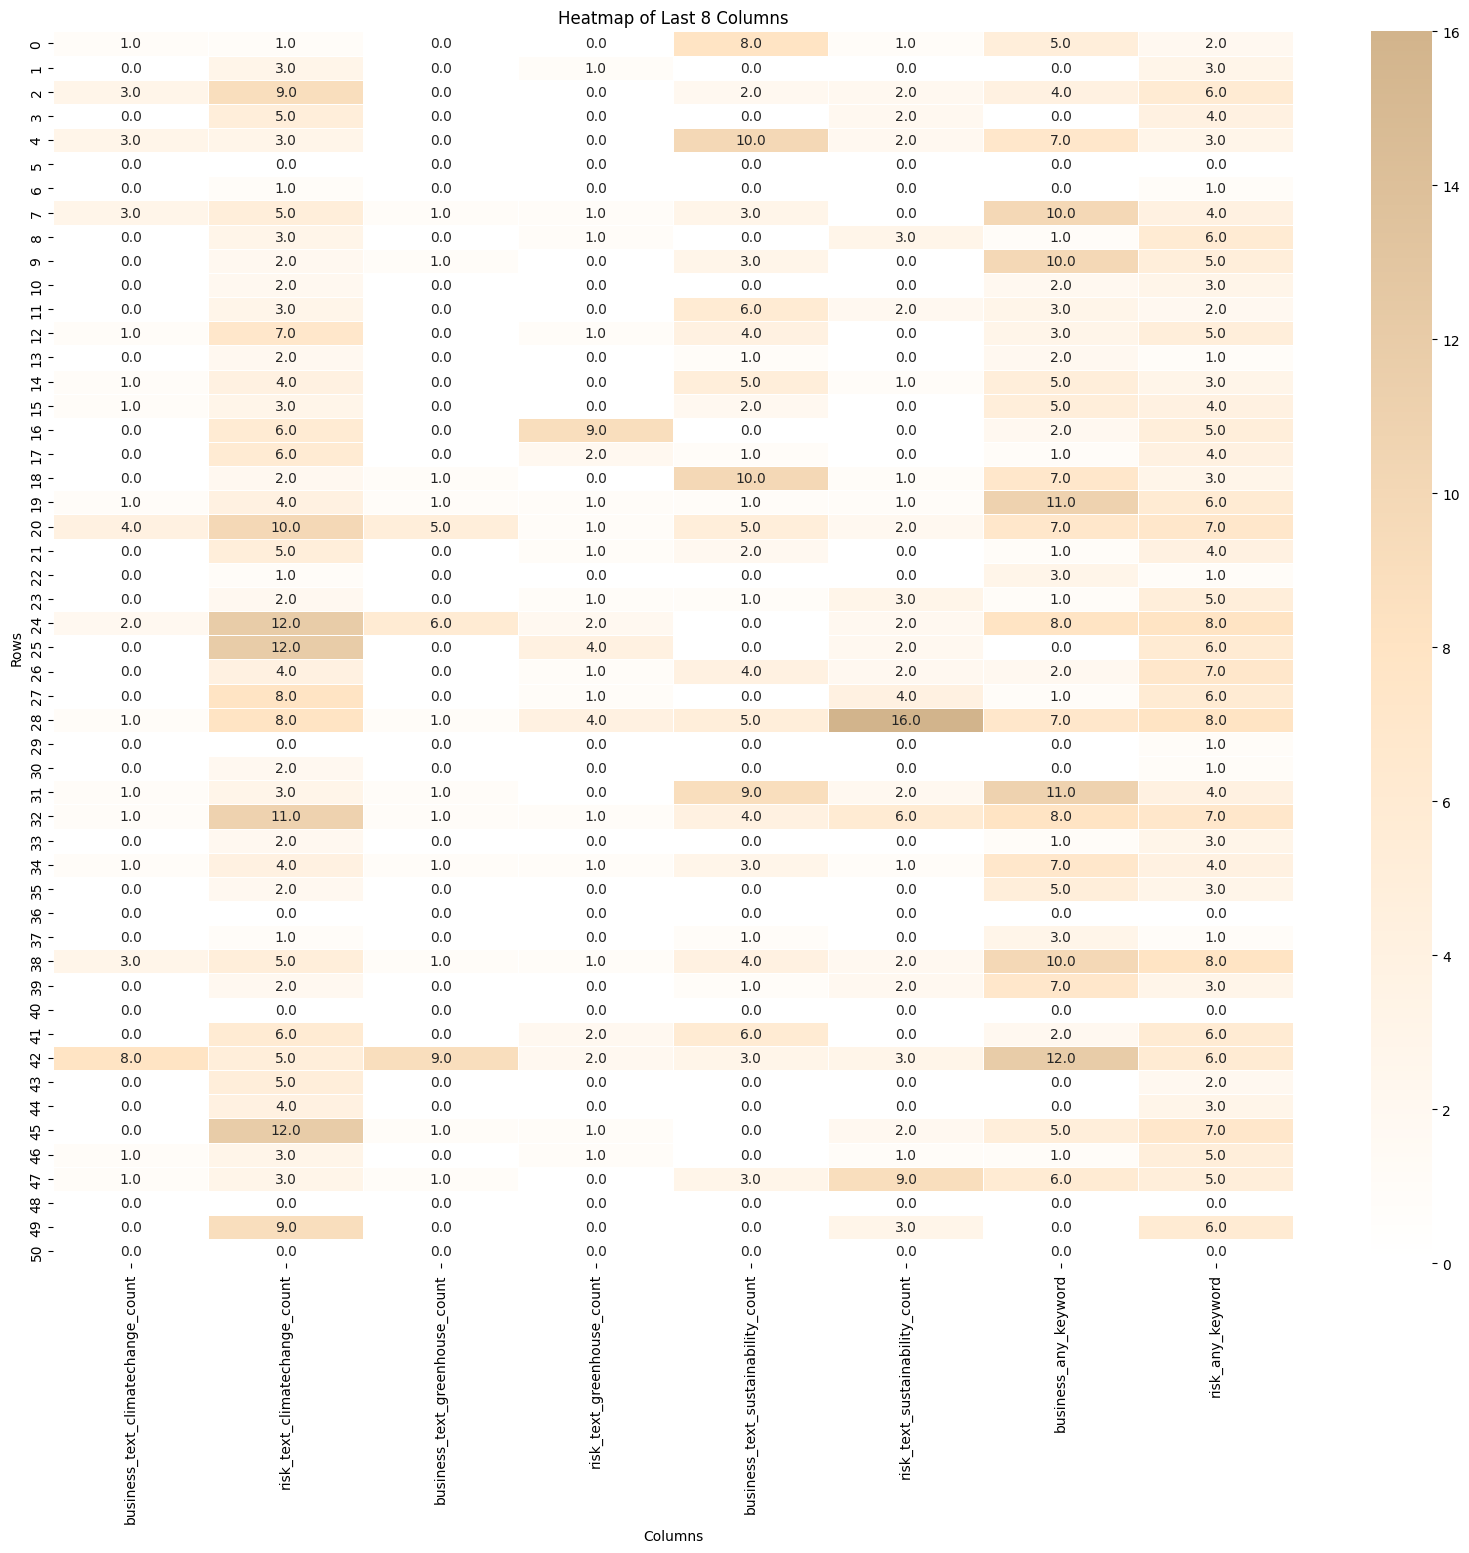

In [80]:
# Custom color map with grey for zero values
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['white', 'bisque', 'tan'])

# Select the last 6 columns
heatmap_data = df.iloc[:, -8:]

# Create the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".1f", linewidths=.5)
plt.title('Heatmap of Last 8 Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [57]:
df.head()

,Rank,company_name,stock_symbol,website,market_cap,market_cap_pretty,Filed for Year,Filed,Filed For Date,SEC_10K,...,business_text_clean,risk_text_clean,business_text_climatechange_count,risk_text_climatechange_count,business_text_greenhouse_count,risk_text_greenhouse_count,business_text_sustainability_count,risk_text_sustainability_count,business_any_keyword,risk_any_keyword
0,1,Microsoft,MSFT,https://www.microsoft.com,"$3,002,343,620,608",3002 B,2023.0,7/27/2023,6/30/2023,https://www.sec.gov/Archives/edgar/data/789019...,...,ITEM 1. B USINESS GENERAL Embracing Our Futur...,ITEM 1A. RIS K FACTORS Our operations and fin...,1,1,0,0,8,1,5,2
1,2,Apple Inc.,AAPL,https://www.apple.com,"$2,815,212,650,496",2815 B,2023.0,11/3/2023,9/30/2023,https://www.sec.gov/Archives/edgar/data/320193...,...,Item 1. Business Company Background The Compa...,"Item 1A. Risk Factors The Company’s business,...",0,3,0,1,0,0,0,3
2,3,Nvidia,NVDA,https://www.nvidia.com,"$1,793,541,144,576",1794 B,2023.0,2/24/2023,1/29/2023,https://www.sec.gov/Archives/edgar/data/104581...,...,ITEM 1. BUSINESS Our Company NVIDIA pioneered...,"ITEM 1A. RISK FACTORS In evaluating NVIDIA, t...",3,9,0,0,2,2,4,6
3,4,Amazon,AMZN,https://www.aboutamazon.com,"$1,760,768,032,768",1761 B,2023.0,2/2/2024,12/31/2023,https://www.sec.gov/Archives/edgar/data/101872...,...,Item 1. Business ##TABLE_END This Annual Repo...,Item 1A. Risk Factors ##TABLE_END Please care...,0,5,0,0,0,2,0,4
4,5,Alphabet Inc. (Class A),GOOGL,https://abc.xyz,"$1,754,293,862,400",1754 B,2023.0,1/31/2024,12/31/2023,https://www.sec.gov/Archives/edgar/data/165204...,...,ITEM 1. BUSINESS Overview As our founders Lar...,ITEM 1A. RISK FACTORS Our operations and fina...,3,3,0,0,10,2,7,3


In [77]:
df.to_csv('20240329_S&P50_latest_10K_data_w_section_text.csv')